# Object localization built with a sliding window




### Bachelor Witschaftsingenieur - Prof. Dr. M. Birbaumer - HSLU

Author: **Dr. Umberto Michelucci**

**Note** this is not the way to do object localization but it is very instructive to understand what it is and why you should not do it this way.

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy as np
import os
from  matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from keras.utils import np_utils # To transform labels in categorical
from keras.datasets import mnist # To load the dataset
from keras import backend as K
import keras

In [6]:
import tensorflow
print(tensorflow.__version__)

2.11.0


In [7]:
plt.rcParams['axes.facecolor'] = 'white'

I have trained a classifier already for you on the MNIST dataset. Note this is a simple Feed Forward Neural Network so it means that this is not translational invariant. We will see later how this is important for solving this problem.
So it is only necessary to load it from disk and use it on the different portions of the image.

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

x_train shape: (60000, 28, 28)
60000 train samples


In [10]:
nClasses = 10
y_train = np_utils.to_categorical(y_train,nClasses)
y_test = np_utils.to_categorical(y_test,nClasses)

In [11]:
ffnn = keras.models.load_model('ffnn_model.h5')
cnn = keras.models.load_model('cnn_model.h5')
cnn_augm = keras.models.load_model('cnn_augm_model.h5')

## A look at the dataset

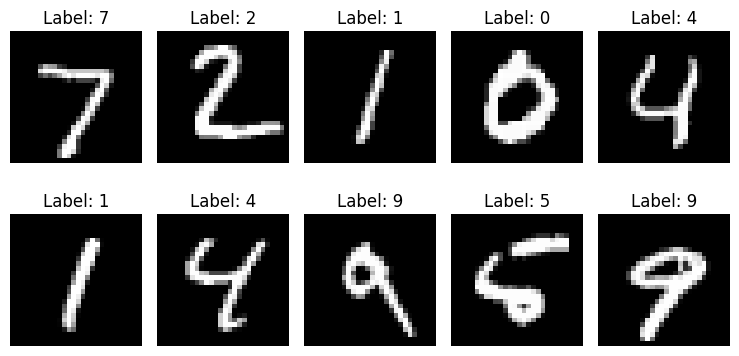

In [12]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_test[i], cmap='gray')
    ax.set_title('Label: {}'.format(np.argmax(y_test[i])))
    ax.set_axis_off()
plt.tight_layout()
plt.show()

# Enlarging the image

Now we will artificially enlarge the image by adding white pixels all around the digit 1 and then we will try to localize it with the sliding window approach.

In [13]:
from PIL import Image, ImageOps
src_img = Image.fromarray((x_test[5]*255).astype(np.uint8).reshape(28,28))
newimg = ImageOps.expand(src_img,border=56,fill='black')

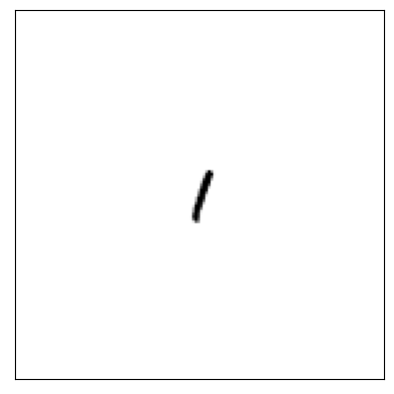

In [14]:
#plt.xscale(0,140)
fig = plt.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])
plt.show()

# Localization of the digit

Now we extract a $28\times28$ sliding window starting from the top left with a stride of 10 and we pass this image to our network and we will keep only the one with the highest proability of a digit.

**NOTE**: we save all location where the model gives a prediction of 100% so that we can visualize how confused the model is.

In [15]:
def localize_digit(bigimg, wx, wy, stride, loaded_model):
    """
    This function returns the location of the window with the highest probability of having a one in it.
    The window has the size of (wx,wy) and the stride is the amount of pixels that the windows
    is moved to the right and in the down direction when arrived at the end of the image.
    """
    slidx, slidy = wx, wy

    digit_found = -1
    max_prob = -1
    bbx = -1 # Bounding box x upper left
    bby = -1 # Bounding box y upper left
    max_prob_ = 0.0
    bbx_ = -1
    bby_ = -1
    most_prob_digit = -1
    final_probs = None
    
    multiple_bb = []
    multiple_digits = []

    print ("Input image size:", bigimg.shape)

    maxloopx = (bigimg.shape[0] -wx) // stride
    maxloopy = (bigimg.shape[1] -wy) // stride

    for slicey in range (0, maxloopx*stride, stride):
        for slicex in range (0, maxloopy*stride, stride):
            slice_ = bigimg[slicex:slicex+wx, slicey:slicey+wx]
            # We resize the image to a 28x28 pixels size
            img_ = Image.fromarray(slice_).resize((28, 28), Image.NEAREST) 
            probs = loaded_model.predict(np.array(img_).reshape(1,28,28,1))

            if (np.max(probs > 0.1)):
                most_prob_digit = np.argmax(probs)
                max_prob_ = np.max(probs)
                bbx_ = slicex
                bby_ = slicey
                #print("Prob", probs)

            if (np.max(probs) == 1.0):
                multiple_digits.append(np.argmax(probs))
                multiple_bb.append([slicex, slicey])
                
            if (max_prob_ >= max_prob):
                final_probs = probs
                max_prob = max_prob_
                bbx = bbx_
                bby = bby_
                digit_found = most_prob_digit

    return max_prob, bbx, bby, digit_found, multiple_digits, multiple_bb

# IMPORTANT NOTE ON THE VISUALISAZION

The rectangles that are on the images, are the regions for which the network gives a probability of 100% for some digits. This happens for multiple regions and therefore there is an additional question of which region to choose.

## Windows (28,28) with stride = 28

Input image size: (140, 140)
1/1 [==============================] - 0s 32ms/step


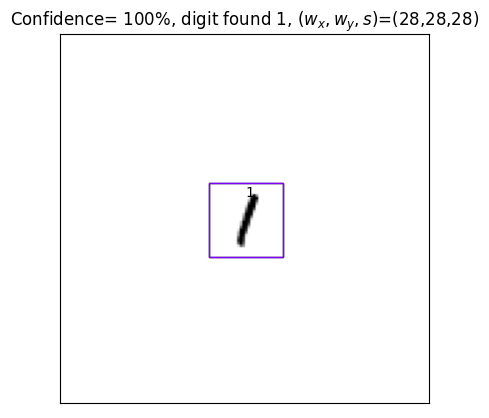

In [16]:
wx = 28
wy = 28
s = 28
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, ffnn)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=1,edgecolor= 'black',facecolor='none'))

color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
i = 0
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1
plt.show()


## Windows (14,28) with stride = 14

Input image size: (140, 140)
1/1 [==============================] - 0s 26ms/step


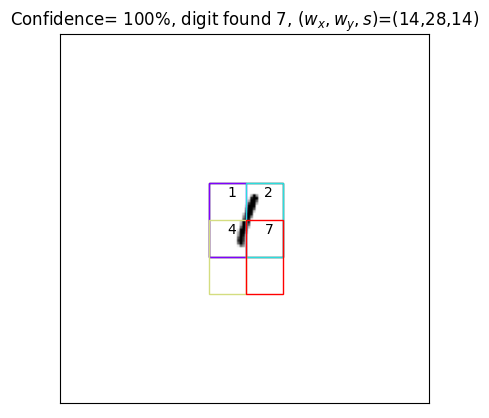

In [17]:
wx = 14
wy = 28
s = 14
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, ffnn)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=1,edgecolor= 'black',facecolor='none'))

color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
i = 0
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1
    
plt.show()


## Windows (30,30) with stride = 10

Input image size: (140, 140)
1/1 [==============================] - 0s 33ms/step


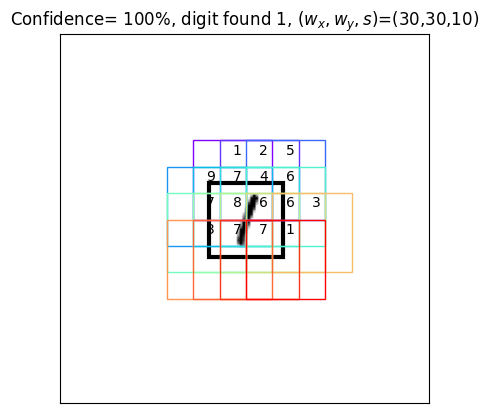

In [18]:
wx = 30
wy = 30
s = 10
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, ffnn)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=3,edgecolor= 'black',facecolor='none'))

color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
i = 0
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1

# Tests with a CNN

## Windows (28,28) with stride = 1

Input image size: (140, 140)
1/1 [==============================] - 0s 28ms/step


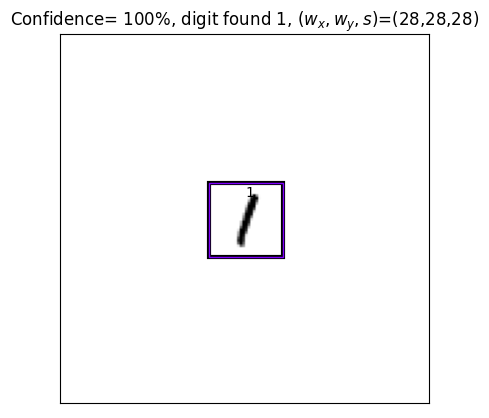

In [19]:
wx = 28
wy = 28
s = 28
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, cnn)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])


# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=3,edgecolor= 'black',facecolor='none'))


color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
i = 0
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1



## Windows (14,28) with stride = 14

Input image size: (140, 140)
1/1 [==============================] - 0s 144ms/step


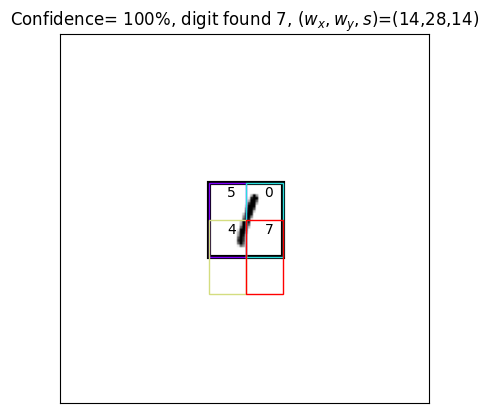

In [20]:
wx = 14
wy = 28
s = 14
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, cnn)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=3,edgecolor= 'black',facecolor='none'))


i = 0
color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1



## Windows (30,30) with stride = 10

Input image size: (140, 140)
1/1 [==============================] - 0s 30ms/step


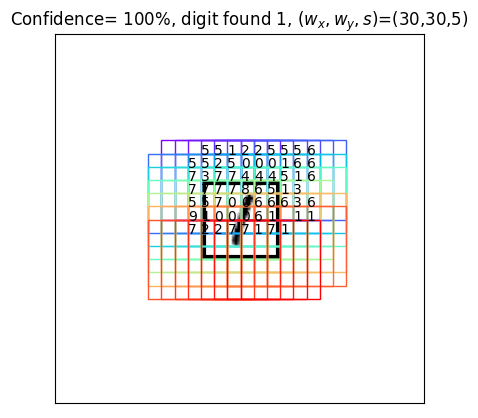

In [21]:
wx = 30
wy = 30
s = 5
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, cnn)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=3,edgecolor= 'black',facecolor='none'))

i = 0
color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1


Input image size: (140, 140)
1/1 [==============================] - 0s 39ms/step


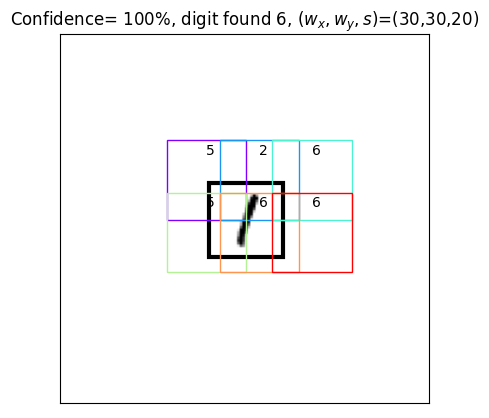

In [22]:
wx = 30
wy = 30
s = 20
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, cnn)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=3,edgecolor= 'black',facecolor='none'))

i = 0
color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1



## Horizonal window

Input image size: (140, 140)
1/1 [==============================] - 0s 27ms/step


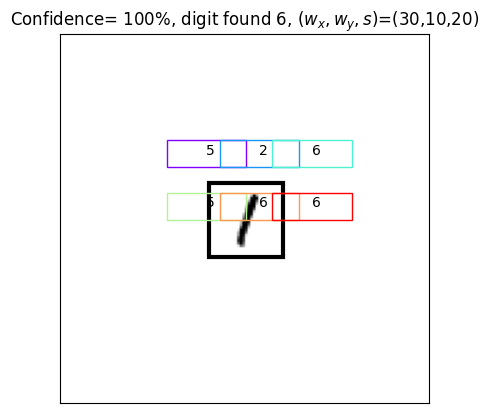

In [23]:
wx = 30
wy = 10
s = 20
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, cnn)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=3,edgecolor= 'black',facecolor='none'))


i = 0
color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1




## Windows (30,30) with stride = 10

Input image size: (140, 140)
1/1 [==============================] - 0s 31ms/step


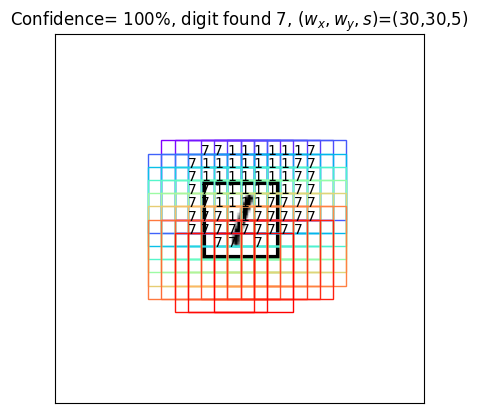

In [24]:
wx = 30
wy = 30
s = 5
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, cnn_augm)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=3,edgecolor= 'black',facecolor='none'))

i = 0
color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1



Input image size: (140, 140)
1/1 [==============================] - 0s 44ms/step


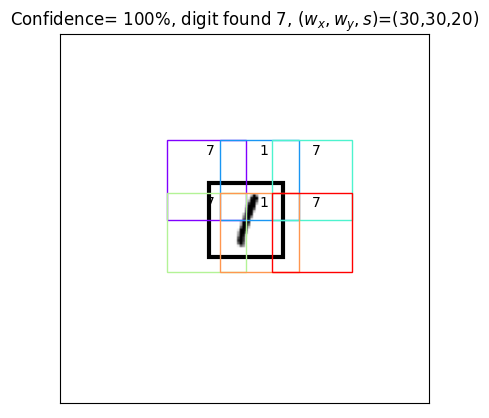

In [25]:
wx = 30
wy = 30
s = 20
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, cnn_augm)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=3,edgecolor= 'black',facecolor='none'))

i = 0
color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1




## Augmented CNN

Input image size: (140, 140)
1/1 [==============================] - 0s 42ms/step


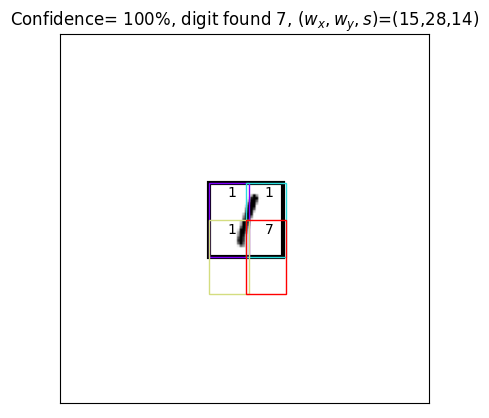

In [26]:
wx = 15
wy = 28
s = 14
max_prob, bbx, bby, digit_found, digits, bbs = localize_digit(np.array(newimg), wx, wx, s, cnn_augm)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

# Plot the original bb
ax.add_patch(patches.Rectangle((70-14, 70-14),28,28,linewidth=3,edgecolor= 'black',facecolor='none'))

i = 0
color=iter(cm.rainbow(np.linspace(0,1,len(bbs))))
for bb in bbs:
    c=next(color)
    rect = patches.Rectangle((bb[0],bb[1]),wx,wy,linewidth=1,edgecolor= c,facecolor='none')
    ax.add_patch(rect)
    ax.text(bb[0]+wx//2, bb[1]+5, str(digits[i]))
    i = i + 1





# Issues with this approach

- Very computationally intensive when using different window sizes
- Impossible to know what ratios are good and which are bad
- The classifier must be really good to identify all the possible classes
- Difficult to implement when multiple instances of an object are present